In [18]:
import os
import sys
from pathlib import Path

import torch
import matplotlib.pyplot as plt

from block.nn import layers

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
root = Path(os.path.abspath("")).parent.parent

In [20]:
n_in = 3
n_out = 1
t_len = 100

single_spike_layer = layers.LinearNeurons(n_in, n_out, "standard", t_len, beta_init=[0.9], single_spike=True)
single_spike_layer.init_weight(single_spike_layer._to_current.weight, "constant", c=1)
torch.manual_seed(2)
multi_spike_layer = layers.LinearNeurons(n_in, n_out, "standard", t_len, beta_init=[0.8])
multi_spike_layer.init_weight(multi_spike_layer._to_current.weight, "constant", c=0)

with torch.no_grad():
    single_spike_layer._to_current.weight[0, 0] -= 0.4
    single_spike_layer._to_current.weight[0, 1] -= 0.5
#     single_spike_layer._to_current.weight[0, 2] -= 0.6
    
    multi_spike_layer._to_current.weight[0, 0] += 0.4
    multi_spike_layer._to_current.weight[0, 1] += 0.5
    multi_spike_layer._to_current.weight[0, 2] += 0.6

single_spike True integrator False
recurrent_source None
single_spike False integrator False
recurrent_source None


In [21]:
def get_input_spikes(thresh=0.56, multi=True):
    torch.manual_seed(0)
    input_spikes = 0.6*torch.rand(n_in, t_len)
    input_spikes[input_spikes > thresh] = 1
    input_spikes[input_spikes < 1] = 0 
    
    if not multi:
        input_spikes *= 0
        input_spikes[0, 23] = 1
        input_spikes[1, 62] = 1
        input_spikes[2, 50] = 1
    
    return input_spikes

def get_unit_and_spike_times(spikes):
    n_units, n_steps = spikes.shape
    
    x = []
    y = []
    
    for n in range(n_units):
        for t in range(n_steps):
            if spikes[n, t] == 1:
                x.append(t)
                y.append(n)
                
    return x, y

single_input_spikes = get_input_spikes(multi=False)
multi_input_spikes = get_input_spikes(multi=True)

In [22]:
with torch.no_grad():
    single_spikes, single_mem, single_current = single_spike_layer(single_input_spikes.unsqueeze(0), return_type=2)
    single_spikes, single_mem, single_current = single_spikes[0, 0], single_mem[0, 0], single_current[0, 0]
    single_mem[single_mem > 1] = 1
    single_intput_time_idx, single_input_unit_idx = get_unit_and_spike_times(single_input_spikes)
    single_output_time_idx, _ = get_unit_and_spike_times(single_spikes.unsqueeze(0))
    
    multi_spikes, multi_mem, multi_current = multi_spike_layer(multi_input_spikes.unsqueeze(0), return_type=2)
    multi_spikes, multi_mem, multi_current = multi_spikes[0, 0], multi_mem[0, 0], multi_current[0, 0]
    multi_mem[multi_mem > 1] = 1
    multi_intput_time_idx, multi_input_unit_idx = get_unit_and_spike_times(multi_input_spikes)
    multi_output_time_idx, _ = get_unit_and_spike_times(multi_spikes.unsqueeze(0))

In [23]:
def plot_activity(mem, current, intput_time_idx, input_unit_idx, output_time_idx):
    fig, axs = plt.subplots(3, 1, figsize=(7, 4))
    
    linewidth = 2.5
    dot_size = 25
    
    for ax in axs:
        ax.set_xticks([])
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.spines["bottom"].set_visible(False)
        ax.spines["left"].set_linewidth(linewidth)
        ax.spines["bottom"].set_linewidth(linewidth)
        ax.set_xlim([0, t_len])
        ax.yaxis.set_tick_params(width=linewidth, length=5)
        ax.xaxis.set_tick_params(width=linewidth, length=5)
        ax.set_yticks([0, 1])
        ax.tick_params(axis="both", which="major", pad=5, labelsize=15) 
    
    axs[0].plot(mem, linewidth=3.0)
    axs[0].scatter(output_time_idx, [[1.2] * len(output_time_idx)], s=dot_size)
    axs[0].plot([0, t_len], [1, 1], ":", c="gray", linewidth=linewidth)
    axs[0].set_ylabel("V", fontsize=25, labelpad=5)
    
    axs[1].plot(current, linewidth=3.0)
    axs[1].set_ylabel("I", fontsize=25, labelpad=5)
    axs[1].set_ylim([0, 0.95])

    axs[2].scatter(intput_time_idx, input_unit_idx, s=dot_size, c="black")
    axs[2].spines["bottom"].set_visible(True)
    axs[2].spines["bottom"].set_linewidth(0)
    axs[2].spines["left"].set_visible(False)
    axs[2].xaxis.set_tick_params(width=0, length=5)
    axs[2].set_xticks([0, t_len])
    axs[2].tick_params(axis="both", which="major", pad=5, labelsize=15) 
    axs[2].set_yticks([])
    axs[2].set_xticklabels([])
    
    return axs

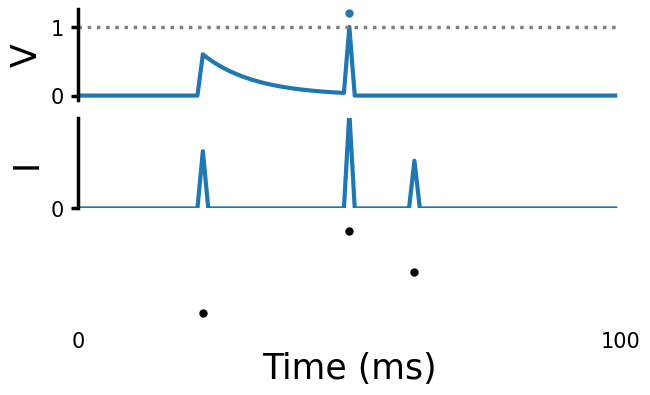

In [24]:
axs = plot_activity(single_mem, single_current, single_intput_time_idx, single_input_unit_idx, single_output_time_idx)
axs[2].set_xticklabels([0, t_len])
axs[2].set_xlabel("Time (ms)", fontsize=25, labelpad=0)
plt.savefig(f"{root}/figures/figure1a.svg", dpi=300, bbox_inches="tight")

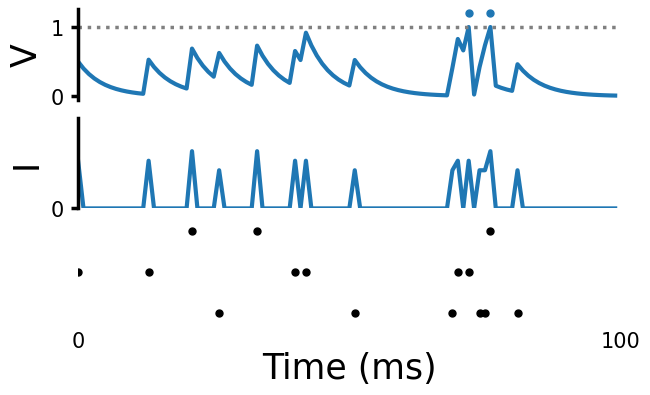

In [26]:
axs = plot_activity(multi_mem, multi_current, multi_intput_time_idx, multi_input_unit_idx, multi_output_time_idx)
axs[2].set_xticklabels([0, t_len])
axs[2].set_xlabel("Time (ms)", fontsize=25, labelpad=0)
plt.savefig(f"{root}/figures/figure1b.svg", dpi=300, bbox_inches="tight")